<div style="font-size: 14pt"><b>Battle of the Plotting Libraries 2.0</b><br/>
DesertPy x PyData<br/>
Wednesday, January 22, 2020<br/>
Tom Dierickx using Seaborn</div>

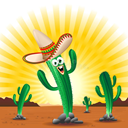

<b>Part 1/3: load data and take a look at what we have to work with</b>

In [1]:
# MODULES TO USE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels

%matplotlib inline

In [2]:
# CONFIGURE DEFAULT SEABORN PLOTS 
sns.set(rc={'figure.figsize':(16, 8)})

In [3]:
# CONFIGURE PANDAS OUTPUT
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 9999)
pd.set_option('display.max_colwidth', 9999)
pd.set_option('display.html.table_schema', True)

# CUSTOM DATA FRAME STYLE CAN APPLY BY CALLING
# df.head().style.set_table_styles(tom_df_style)
tom_df_style = [
    dict(selector="td", props=[('font-family','Consolas'), ('font-size','8pt'), ('vertical-align','top'), ('text-align','left'), ('white-space', 'pre')]),
    dict(selector="th", props=[('font-family','Consolas'), ('font-size','8pt'), ('vertical-align','top'), ('text-align','left'), ('white-space', 'pre')])
]

In [4]:
# LOAD DATA FILE (WE NOTICE SOME RECENT MONTHS HAVE "M" FOR MISSING DATA)
df_phx_data = pd.read_csv("https://raw.githubusercontent.com/pydata-phoenix/battle-of-the-plotting-libraries/master/data/phoenix_maximum_daily_temps.csv", na_values=["M"])
df_phx_data.set_index("Year", inplace=True)
df_phx_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 1919 to 2019
Data columns (total 12 columns):
Jan    101 non-null int64
Feb    101 non-null int64
Mar    101 non-null int64
Apr    101 non-null int64
May    101 non-null int64
Jun    101 non-null int64
Jul    101 non-null int64
Aug    100 non-null float64
Sep    100 non-null float64
Oct    100 non-null float64
Nov    100 non-null float64
Dec    100 non-null float64
dtypes: float64(5), int64(7)
memory usage: 10.3 KB


In [5]:
df_phx_data.head().style.set_table_styles(tom_df_style)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1919,74,74,86,97,101,113,110,110,106,90,84,76
1920,79,76,83,94,105,110,114,108,105,98,79,75
1921,77,92,95,96,101,110,110,107,105,100,89,76
1922,69,80,83,92,105,114,112,110,107,100,80,74
1923,84,82,84,92,104,112,111,105,105,92,80,71


In [6]:
df_phx_data.tail().style.set_table_styles(tom_df_style)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2015,81,84,97,99,107,115,110,117,107,106,88,79
2016,76,90,92,97,102,118,112,111,106,100,90,77
2017,76,83,96,99,108,119,118,111,110,99,89,84
2018,83,84,92,100,106,111,116,114,109,93,84,75
2019,74,77,87,100,100,112,110,nan,nan,nan,nan,nan


In [7]:
# TAKE QUICK PEAK AT DISTRIBUTION OF HIGH TEMPS BY MONTH
df_phx_data.describe().style.set_table_styles(tom_df_style)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,101,101,101,101,101,101,101,100,100,100,100,100
mean,77.4455,82.0495,88.4455,97.0099,104.634,112.089,113.228,110.87,107.59,99.04,87.12,77.59
std,4.13153,4.18898,4.62704,3.65649,3.66257,2.88132,2.3447,2.87678,2.71209,3.51884,4.21944,3.51072
min,65,70,75,87,97,106,107,103,101,89,76,68
25%,75,80,85,95,102,110,112,109,106,96.75,84,75
50%,77,83,89,97,105,112,113,111,107,99,87,77
75%,81,85,91,100,107,114,115,113,109.25,101.25,90,80
max,88,92,100,105,113,122,121,117,116,107,96,87


In [8]:
# FOR MANY ANALYSES AND VISUALIZATIONS, HAVING THE DATA TRANSPOSED INTO VERTICAL FORMAT (AKA, UNPIVOTED) HELPS MAKE THINGS EASIER
df_phx_vdata = pd.melt(df_phx_data.reset_index(), id_vars="Year", var_name="Month").rename(columns={"value":"MaxTemp"})
df_phx_vdata.head(10).style.set_table_styles(tom_df_style)

,Year,Month,MaxTemp
0,1919,Jan,74
1,1920,Jan,79
2,1921,Jan,77
3,1922,Jan,69
4,1923,Jan,84
5,1924,Jan,74
6,1925,Jan,81
7,1926,Jan,72
8,1927,Jan,83
9,1928,Jan,78


In [9]:
# ALSO, HAVING AVERAGE MAX TEMPS BY MONTH WILL BE HELPFUL
stats = df_phx_vdata.groupby(["Month"])["MaxTemp"].aggregate([np.mean,np.std])
stats.style.set_table_styles(tom_df_style)

,mean,std
Month,,
Apr,97.0099,3.65649
Aug,110.87,2.87678
Dec,77.59,3.51072
Feb,82.0495,4.18898
Jan,77.4455,4.13153
Jul,113.228,2.3447
Jun,112.089,2.88132
Mar,88.4455,4.62704
May,104.634,3.66257


In [10]:
# APPEND THE MONTHLY STATS TO EACH ACTUAL MONTH AND COMPUTE Z-SCORES FOR HELPING DETECT OUTLIERS LATER
stats = stats.reset_index().rename(columns={"mean":"MonthlyAvgMaxTemp","std":"MonthlyStdMaxTemp"})
df_phx_vdata = df_phx_vdata.merge(stats, left_on="Month", right_on="Month", suffixes=(False,False))[["Year","Month","MaxTemp","MonthlyAvgMaxTemp","MonthlyStdMaxTemp"]]
df_phx_vdata["zScore"] = (df_phx_vdata["MaxTemp"] - df_phx_vdata["MonthlyAvgMaxTemp"]) / df_phx_vdata["MonthlyStdMaxTemp"]
df_phx_vdata.head().style.set_table_styles(tom_df_style)

,Year,Month,MaxTemp,MonthlyAvgMaxTemp,MonthlyStdMaxTemp,zScore
0,1919,Jan,74,77.4455,4.13153,-0.833964
1,1920,Jan,79,77.4455,4.13153,0.376242
2,1921,Jan,77,77.4455,4.13153,-0.10784
3,1922,Jan,69,77.4455,4.13153,-2.04417
4,1923,Jan,84,77.4455,4.13153,1.58645


In [11]:
# NOW, HAVING A "REAL" MONTH ID TO USE FOR EACH ROW WILL HELP WITH CERTAIN THINGS
df_phx_vdata["MonthID"] = df_phx_vdata.apply(lambda x : pd.Period(str(x["Year"]) + "-" + x["Month"]), axis=1)
df_phx_vdata.set_index("MonthID", inplace=True)
df_phx_vdata.sort_index(inplace=True)
df_phx_vdata.head(10).style.set_table_styles(tom_df_style)

,Year,Month,MaxTemp,MonthlyAvgMaxTemp,MonthlyStdMaxTemp,zScore
MonthID,,,,,,
1919-01,1919,Jan,74,77.4455,4.13153,-0.833964
1919-02,1919,Feb,74,82.0495,4.18898,-1.92159
1919-03,1919,Mar,86,88.4455,4.62704,-0.528533
1919-04,1919,Apr,97,97.0099,3.65649,-0.00270779
1919-05,1919,May,101,104.634,3.66257,-0.992106
1919-06,1919,Jun,113,112.089,2.88132,0.316137
1919-07,1919,Jul,110,113.228,2.3447,-1.3766
1919-08,1919,Aug,110,110.87,2.87678,-0.302422
1919-09,1919,Sep,106,107.59,2.71209,-0.586263


In [12]:
# LASTLY, GROUPING BY DECADE IS INTERESTING (... ALBEIT DEPRESSING)
df_phx_vdata["Decade"] = 10*np.floor(df_phx_vdata["Year"]/10)
df_phx_vdata.head().style.set_table_styles(tom_df_style)
df_phx_vdata.groupby("Decade")["MaxTemp"].describe()

,count,mean,std,min,25%,50%,75%,max
Decade,,,,,,,,
1910.0,12.0,93.416667,14.693588,74.0,82.00,93.5,107.00,113.0
1920.0,120.0,95.275000,13.300637,69.0,83.00,97.5,107.00,118.0
1930.0,120.0,96.050000,13.699568,66.0,83.75,98.0,109.25,116.0
1940.0,120.0,95.616667,13.186563,65.0,83.00,97.5,108.00,116.0
1950.0,120.0,95.358333,12.982079,71.0,84.00,98.0,107.00,118.0
1960.0,120.0,95.133333,13.458266,68.0,84.00,97.0,107.00,115.0
1970.0,120.0,96.658333,13.461739,70.0,84.00,96.5,109.25,117.0
1980.0,120.0,97.658333,13.346385,73.0,85.75,100.0,111.00,118.0
1990.0,120.0,96.900000,13.712780,71.0,85.00,99.5,110.00,122.0


In [13]:
# TOP 5 UNUSUALLY HOT MONTHS (SINCE 1970)
tmp = df_phx_vdata[df_phx_vdata["Year"]>=1970]
tmp.sort_values("zScore", ascending=False).head(5).style.set_table_styles(tom_df_style)

,Year,Month,MaxTemp,MonthlyAvgMaxTemp,MonthlyStdMaxTemp,zScore,Decade
MonthID,,,,,,,
1990-06,1990,Jun,122,112.089,2.88132,3.43971,1990
1995-07,1995,Jul,121,113.228,2.3447,3.31483,1990
1971-01,1971,Jan,88,77.4455,4.13153,2.55461,1970
1988-03,1988,Mar,100,88.4455,4.62704,2.49716,1980
2017-06,2017,Jun,119,112.089,2.88132,2.39852,2010


In [14]:
# TOP 5 UNUSUALLY COLD MONTHS (SINCE 1970)
tmp = df_phx_vdata[df_phx_vdata["Year"]>=1970]
tmp.sort_values("zScore", ascending=True).head(5).style.set_table_styles(tom_df_style)

,Year,Month,MaxTemp,MonthlyAvgMaxTemp,MonthlyStdMaxTemp,zScore,Decade
MonthID,,,,,,,
1973-03,1973,Mar,75,88.4455,4.62704,-2.90586,1970
2000-11,2000,Nov,76,87.12,4.21944,-2.63542,2000
2005-02,2005,Feb,72,82.0495,4.18898,-2.39904,2000
1971-05,1971,May,97,104.634,3.66257,-2.08423,1970
1976-09,1976,Sep,102,107.59,2.71209,-2.06114,1970


<b>Part 2/3: look at data visually by month</b>

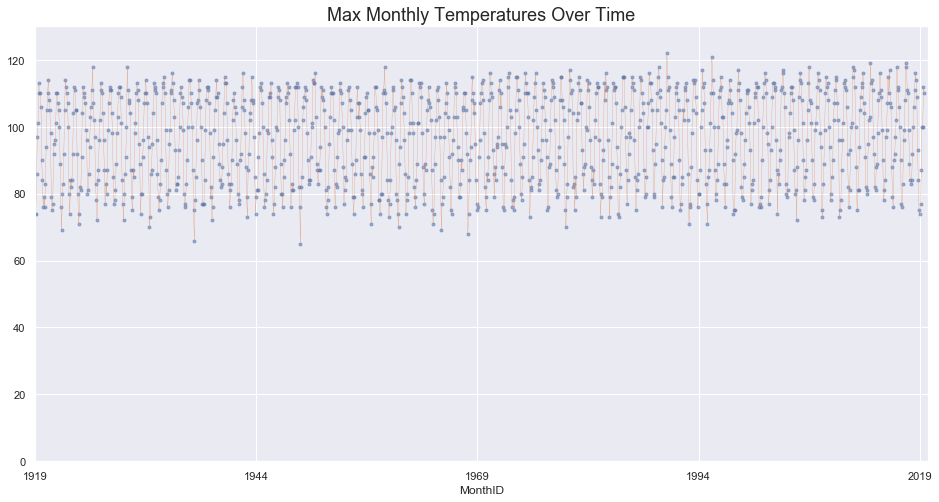

In [15]:
# LOOK AT ALL POINTS
f, ax = plt.subplots()
plt.title("Max Monthly Temperatures Over Time", fontsize=18)
ax.set(ylim=(0, 130))
df_phx_vdata["MaxTemp"].plot(marker=".", alpha=0.5, linestyle="None");
df_phx_vdata["MaxTemp"].plot(linewidth=0.25);

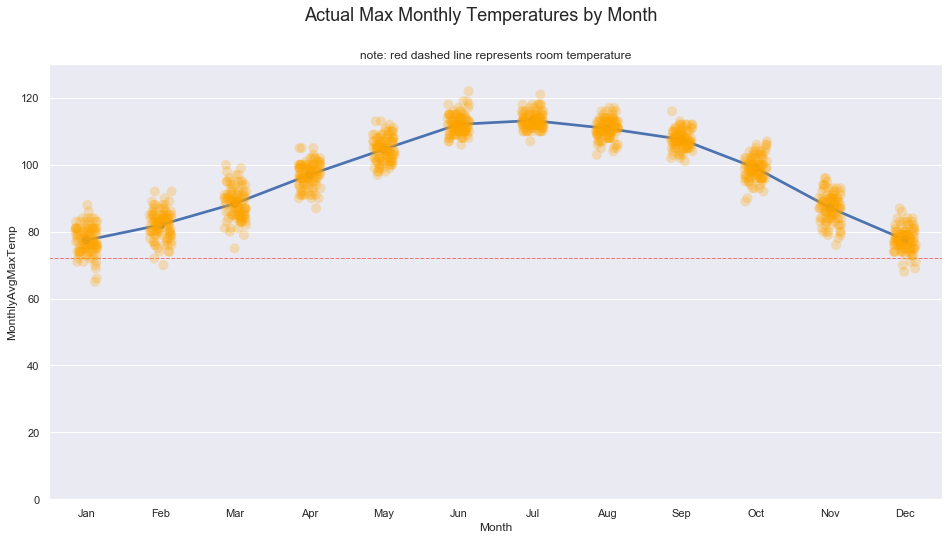

In [16]:
# ALL POINTS PLOTTED WITH MONTHLY AVG-MAX TEMPS DRAWN ON TOP
Months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
f, ax = plt.subplots()
plt.suptitle("Actual Max Monthly Temperatures by Month", fontsize=18)
plt.title("note: red dashed line represents room temperature")
ax.set(ylim=(0, 130))
ax.axhline(72, ls='--', color="red", linewidth=1, alpha=0.5)
sns.stripplot(x="Month", y="MaxTemp", data=df_phx_vdata, order=Months, color="orange", dodge=True, jitter=0.15, alpha=0.25, size=10, ax=ax);
sns.pointplot(x="Month", y="MonthlyAvgMaxTemp", data=df_phx_vdata, sort=Months, ax=ax);

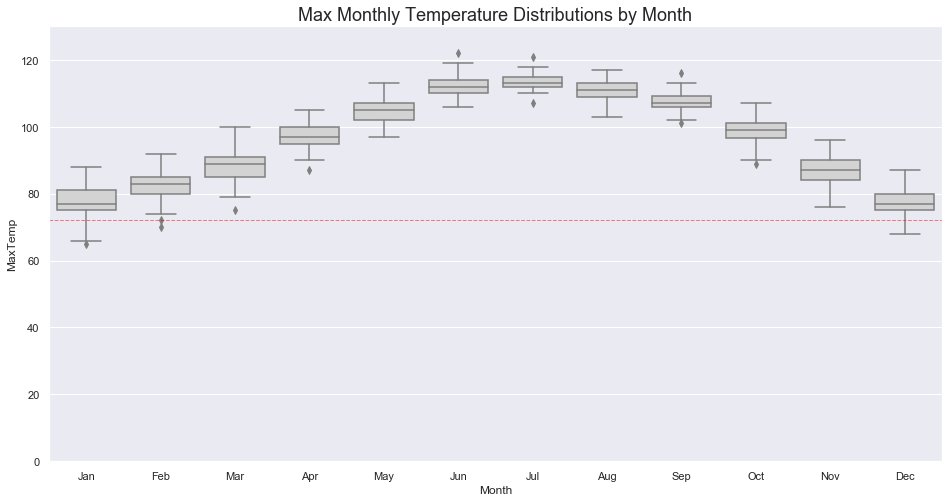

In [17]:
# LOOK AT BOXPLOTS BY MONTH
f, ax = plt.subplots()
plt.title("Max Monthly Temperature Distributions by Month", fontsize=18)
ax.set(ylim=(0, 130))
sns.boxplot(x="Month", y="MaxTemp", data=df_phx_vdata, color="lightgray", ax=ax);
ax.axhline(72, ls='--', color="red", linewidth=1, alpha=0.5);

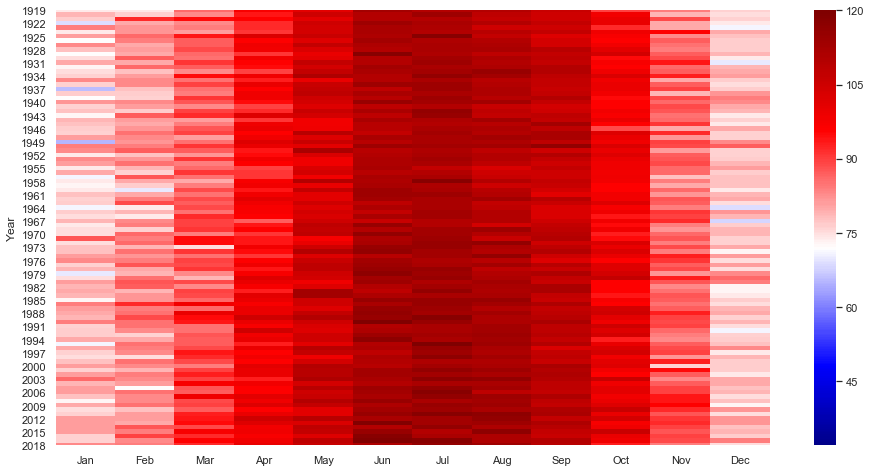

In [18]:
# CREATE HEATMAP (NO PUN INTENDED) SHOWING MAX TEMPS BY MONTH AND YEAR, USING CUSTOM DIVERGINING COLORMAP WITH STANDARD ROOM TEMPERATURE AS CENTER
f, ax = plt.subplots()
sns.heatmap(df_phx_data, center=72, vmin=32, vmax=120, cmap="seismic", ax=ax);

<b>Part 3/3: look at data visually by decade</b>

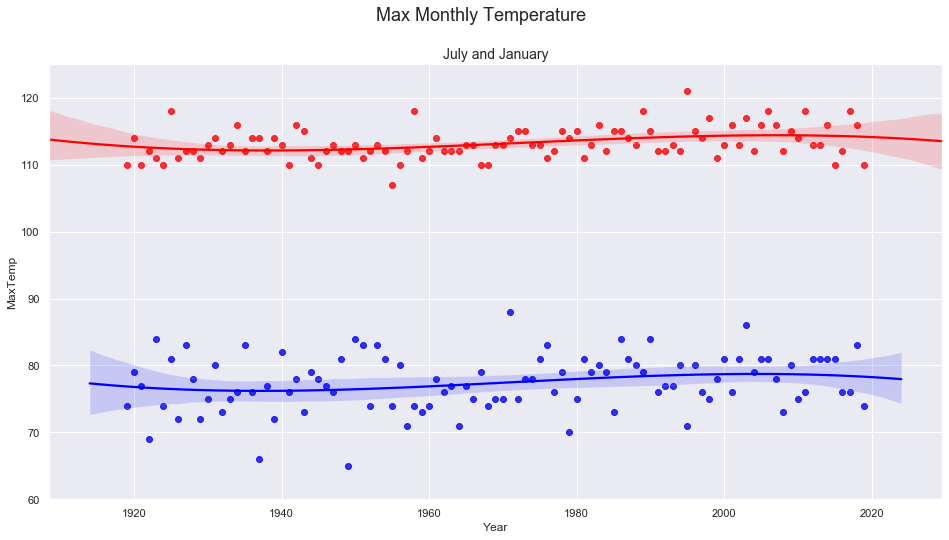

In [19]:
#LOOK AT TRENDS OVER TIME FOR JUST JAN AND JUL
f, ax = plt.subplots()
plt.suptitle("Max Monthly Temperature", fontsize=18)
plt.title("July and January", fontsize=14)
ax.set(ylim=(60, 125))

sns.regplot(x="Year", y="MaxTemp", data=df_phx_vdata[df_phx_vdata["Month"]=="Jan"], color="blue", order=3, ax=ax);
sns.regplot(x="Year", y="MaxTemp", data=df_phx_vdata[df_phx_vdata["Month"]=="Jul"], color="red", order=3, ax=ax);

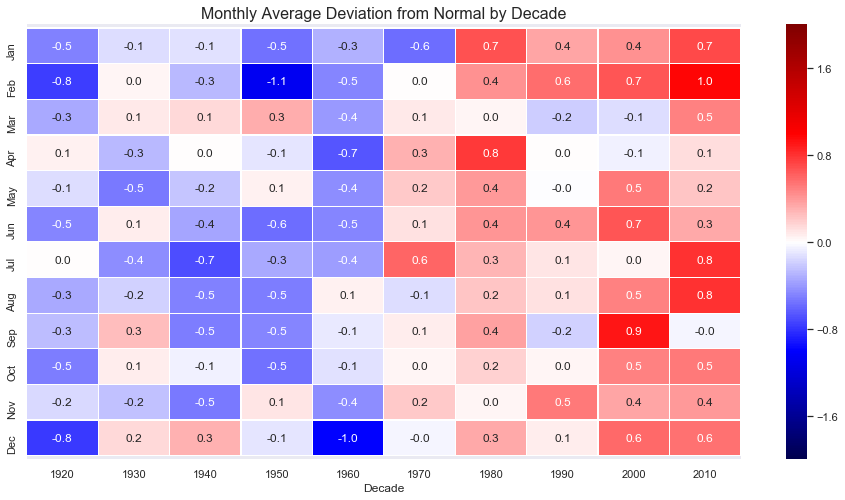

In [20]:
# CREATE HEATMAP SHOWING MAX TEMP DEVIATIONS BY EACH MONTH'S MEAN VERSUS DECADE
f, ax = plt.subplots()
plt.title("Monthly Average Deviation from Normal by Decade", fontsize=16)
Months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
tmp = df_phx_vdata[df_phx_vdata["Year"]>=1920].pivot_table(values="zScore", index="Decade", columns="Month", aggfunc=np.mean)
tmp.columns = Months
xticklabels = [int(x) for x in tmp.transpose().columns]
sns.heatmap(tmp.transpose(), xticklabels=xticklabels, center=0, vmin=-2, vmax=2, cmap="seismic", annot=True, fmt="0.1f", linewidths=0.25, ax=ax);
ax.set_ylim(12.1, -0.1);

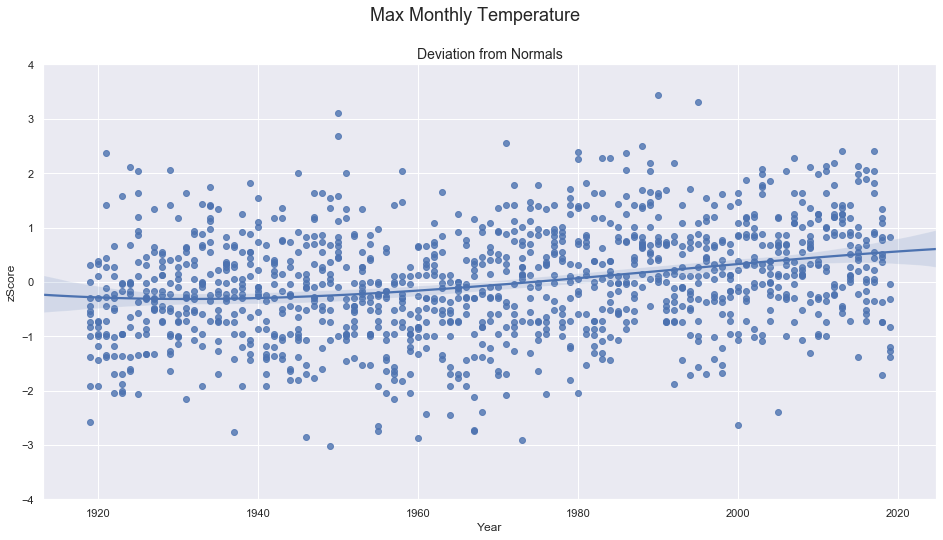

In [21]:
#LOOK AT TRENDS OVER TIME
f, ax = plt.subplots()
plt.suptitle("Max Monthly Temperature", fontsize=18)
plt.title("Deviation from Normals", fontsize=14)
ax.set(ylim=(-4, 4))
sns.regplot(x="Year", y="zScore", data=df_phx_vdata, order=3, ax=ax);

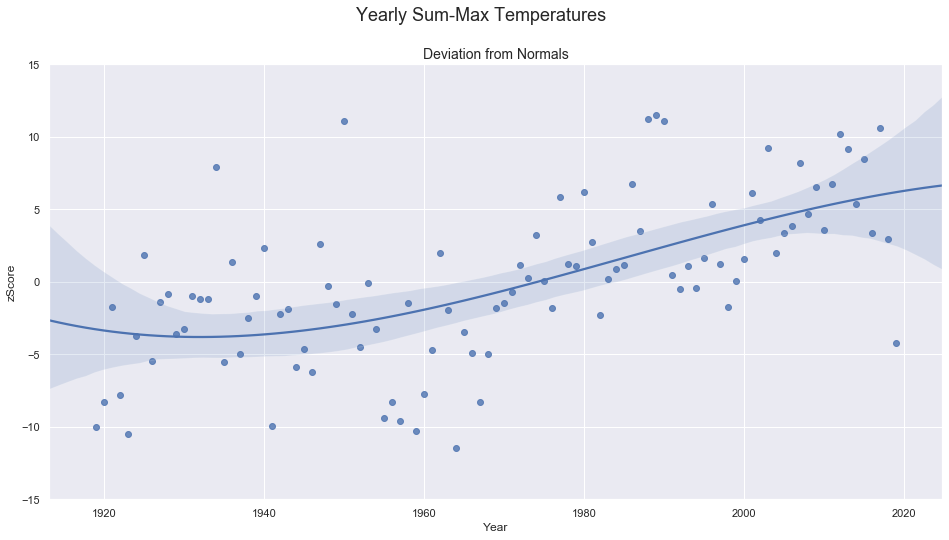

In [22]:
# Yearly deviations from normal
tmp = df_phx_vdata.groupby("Year")["zScore"].sum().reset_index()
f, ax = plt.subplots()
plt.suptitle("Yearly Sum-Max Temperatures", fontsize=18)
plt.title("Deviation from Normals", fontsize=14)
ax.set(ylim=(-15, 15))
sns.regplot(x="Year", y="zScore", data=tmp, order=3, ax=ax);

<b>Conclusions</b>

<ol>
    <li>Every month every year can be expected to have 1+ day warmer than room temperature (72) ... doesn't happen in Chicago!</li>
    <li>Historiclaly, March has the most variation <i>(std=4.6)</i> and July the least <i>(std=2.3)</i></li>
    <li>Winter months used to be coolor until early 1970's</li>
    <li>There's been a very significant warm-up, generally, since early 1970's</li>
    <li>2019 was unusually cooler than normal ... let's hope a new trend is beginning!</li>
</ol>    